In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
from rich import print
import warnings
import datetime
from astropy.time import Time
import os

In [2]:
def counts2mag(cps, band):
    scale = 18.82 if band == 'FUV' else 20.08
    with np.errstate(invalid='ignore'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mag = -2.5 * np.log10(cps) + scale
    return mag

In [3]:
def angularSeparation(ra1, dec1, ra2, dec2):

    d2r = np.pi/180.
    ra2deg = 1./d2r

    d1 = dec1*d2r
    d2 = dec2*d2r

    r1 = ra1*d2r
    r2 = ra2*d2r

    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))

    return r*ra2deg

In [4]:
header_data = pd.read_csv('../ref/mislike_image_header_table.csv')
catalog_filename = '../ref/catalog_nd_daostarfinder.parquet'
catalog_file = pq.ParquetFile(catalog_filename)

In [5]:
def make_target_table(objid_list,morphology=''):
    table = pd.DataFrame()
    for objid in objid_list:
        eclipse = int(str(objid)[-5:])
        this_star = pq.read_table(catalog_filename,filters =
                                  [('eclipse','=',eclipse),
                                   ('obj_id','=',objid)]).to_pandas()
        this_star['morphology'] = morphology
        table = pd.concat([table,this_star[["eclipse","obj_id","ra","dec","morphology"]]])
    return table

In [6]:
os.listdir("/Users/cm/GFCAT/gfcat/test_known_jpg/sorted/")

['marginal',
 '.DS_Store',
 'eclipse',
 'trend',
 'moving',
 'artifact',
 'unk variable',
 'flare']

In [7]:
gfcat_corpus = pd.DataFrame()
path = "/Users/cm/GFCAT/gfcat/test_gifs/sorted/"
for d in ['flare','eclipse','trend','unk variable']:
    targets = []
    for fn in os.listdir(f"{path}{d}/"):
        try:
            targets+=[int(fn.split('-')[1])]
        except IndexError:
            continue
    table = make_target_table(targets,morphology=d.upper()[0])
    gfcat_corpus = pd.concat([gfcat_corpus,table])
print(f'{len(gfcat_corpus)} sources found in general search')

gfcat_targeted = pd.DataFrame()
path = "/Users/cm/GFCAT/gfcat/test_known_jpg/sorted/"
for d in ['flare','eclipse','trend','unk variable']:
    targets = []
    for fn in os.listdir(f"{path}{d}/"):
        try:
            targets+=[int(fn.split('-')[1])]
        except IndexError:
            continue
    table = make_target_table(targets,morphology=d.upper()[0])
    gfcat_targeted = pd.concat([gfcat_targeted,table])
print(f'{len(gfcat_targeted)} sources found in targeted search')

gfcat_fuv_matched = pd.DataFrame()
path = "/Users/cm/GFCAT/gfcat/test_fuv_matched/sorted/"
for d in ['flare','eclipse','trend','unk variable']:
    targets = []
    for fn in os.listdir(f"{path}{d}/"):
        try:
            targets+=[int(fn.split('-')[1])]
        except IndexError:
            continue
    table = make_target_table(targets,morphology=d.upper()[0])
    gfcat_fuv_matched = pd.concat([gfcat_fuv_matched,table])
print(f'{len(gfcat_fuv_matched)} sources found in matched FUV targets')



865 sources found in general search

654 sources found in targeted search

281 sources found in matched FUV targets

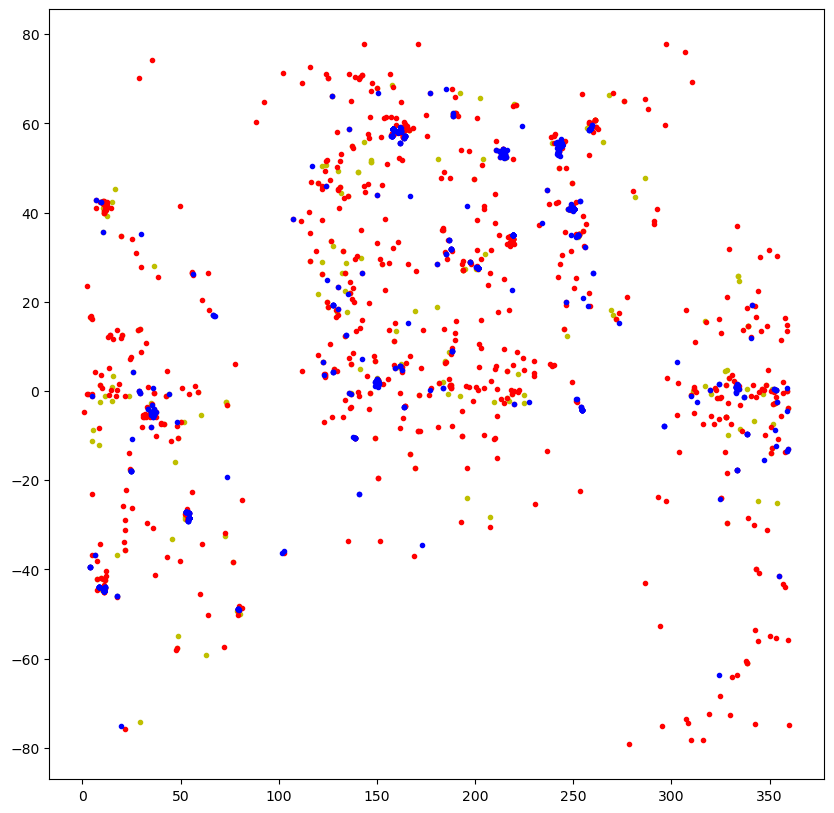

In [8]:
plt.figure(figsize=(10,10))
plt.plot(gfcat_fuv_matched['ra'],gfcat_fuv_matched['dec'],'y.')
plt.plot(gfcat_corpus['ra'],gfcat_corpus['dec'],'r.')
plt.plot(gfcat_targeted['ra'],gfcat_targeted['dec'],'b.')


In [9]:
# crossmatch corpus to targeted
n=0
for target in gfcat_corpus.iterrows():
    ra,dec = target[1]['ra'],target[1]['dec']
    dist = angularSeparation(gfcat_targeted['ra'].values,gfcat_targeted['dec'].values,ra,dec)
    if dist.min()<0.0005:
        #print(ra,dec,dist.min())
        n+=1
print(f"{n} of {len(gfcat_targeted)} targeted sources were found in general search.")

# crossmatch targeted to corpus
n=0
for target in gfcat_targeted.iterrows():
    ra,dec = target[1]['ra'],target[1]['dec']
    dist = angularSeparation(gfcat_corpus['ra'].values,gfcat_corpus['dec'].values,ra,dec)
    if dist.min()<0.0005:
        #print(ra,dec,dist.min())
        n+=1
print(f"{n} of {len(gfcat_corpus)} general search sources were found in targeted search.")


165 of 654 targeted sources were found in general search.

426 of 865 general search sources were found in targeted search.

In [10]:
n=0
for target in gfcat_corpus.iterrows():
    ra,dec = target[1]['ra'],target[1]['dec']
    dist = angularSeparation(gfcat_corpus['ra'].values,gfcat_corpus['dec'].values,ra,dec)
    if any (np.sort(dist)[1:]<0.005):
        #print(ra,dec,dist.min())
        n+=1
print(f"{n} corpus sources are repeated")


n=0
for target in gfcat_targeted.iterrows():
    ra,dec = target[1]['ra'],target[1]['dec']
    dist = angularSeparation(gfcat_targeted['ra'].values,gfcat_targeted['dec'].values,ra,dec)
    if any (np.sort(dist)[1:]<0.005):
        #print(ra,dec,dist.min())
        n+=1
print(f"{n} targeted sources are repeated")


179 corpus sources are repeated

508 targeted sources are repeated

In [11]:
def make_variable_target_table(obj_ids):
    variable_table = pd.DataFrame()
    for obj_id in obj_ids:
        eclipse = int(str(obj_id)[-5:])
        #obj_id = int(objid)
        this_star = pq.read_table(catalog_filename,filters =
                                  [('eclipse','=',eclipse),
                                   ('obj_id','=',obj_id)]).to_pandas()
        expt = header_data.loc[header_data['ECLIPSE']==eclipse].loc[header_data['BAND']=='NUV']['EXPT_0']
        cps = this_star["aperture_sum_n_12_8"].tolist()[0]/expt.tolist()[0]
        cps_err = np.sqrt(this_star["aperture_sum_n_12_8"].tolist()[0])/expt.tolist()[0]
        mag = counts2mag(cps,'NUV')
        mag_err_1 = mag-counts2mag(cps+cps_err,'NUV')
        mag_err_2 = counts2mag(cps-cps_err,'NUV')-mag # this one is always larger
        this_star['cps'] = cps
        this_star['cps_err'] = cps_err
        this_star['NUVmag'] = mag
        this_star['NUVmag_err_1'] = mag_err_1
        this_star['NUVmag_err_2'] = mag_err_2
        variable_table = pd.concat([variable_table,
                                 this_star[
                                    ["obj_id","ra","dec","eclipse","NUVmag","NUVmag_err_1","NUVmag_err_2",]]])
    return variable_table


In [12]:
mpt = """06882 2182706882 310.03898  -0.86965 F
15112 583415112  173.68275  45.53918 F
29166 1128729166 355.72871   1.65753 F
29390 1588929390  10.92245 -42.34763 U
29643 965529643   53.06506 -29.51007 U
43201 738043201  217.15856  57.75332 U
03858 614703858  135.96049  52.35710 F
04028 404904028  189.00277  62.49956 F
07940 555607940    6.43415  17.08139 F
09709 1055909709 164.46273  -3.76613 U
13533 3357413533  16.65372  45.38989 F
13656 613113656   24.76303 -17.94913 F
16497 1520916497 219.53099  33.10083 F
18081 80418081   358.46939 -10.54433 F
18380 3958418380   7.70821 -71.84528 F
18753 958718753   51.26207 -17.21407 F
23505 1597023505  13.11492   0.09855 F
26488 1218326488 212.80185   6.83090 F
28619 1333228619 326.15289   0.70565 F
30122 549930122   53.00912 -27.04739 F
30668 1439130668 133.73297   2.57409 F
31274 1708031274 120.70829  36.45803 F
36705 1284736705 146.54298  15.54300 F
40521 1328540521  29.19705  -0.35408 F
40930 3656640930  70.63517  18.43965 F
42499 766342499  165.10157  12.73207 F
43238 1530943238 243.41123  54.66503 F
43828 1063943828 338.34099 -60.93026 F
44684 3062344684 308.13204   7.97132 F
45629 1000545629 160.64052  76.02885 F"""

gfcat_adjusted = pd.DataFrame(
    {'eclipse':np.array(np.array([t.split() for t in mpt.split('\n')])[:,0],dtype='int'),
     'ra':np.array(np.array([t.split() for t in mpt.split('\n')])[:,2],dtype='float'),
     'dec':np.array(np.array([t.split() for t in mpt.split('\n')])[:,3],dtype='float'),
     'morphology':np.array(np.array([t.split() for t in mpt.split('\n')])[:,4],dtype='str')})
gfcat_adjusted

,eclipse,ra,dec,morphology
0,6882,310.03898,-0.86965,F
1,15112,173.68275,45.53918,F
2,29166,355.72871,1.65753,F
3,29390,10.92245,-42.34763,U
4,29643,53.06506,-29.51007,U
5,43201,217.15856,57.75332,U
6,3858,135.96049,52.35710,F
7,4028,189.00277,62.49956,F
8,7940,6.43415,17.08139,F
9,9709,164.46273,-3.76613,U


In [13]:
# compile both targeted and untargeted sources
gfcat_draft = pd.concat([make_variable_target_table(gfcat_corpus['obj_id'].values),
                         make_variable_target_table(gfcat_targeted['obj_id'].values),
                         make_variable_target_table(gfcat_fuv_matched['obj_id'].values)])
%time print(len(gfcat_draft))

1800

CPU times: user 1.79 ms, sys: 4.34 ms, total: 6.13 ms
Wall time: 6.22 ms


In [14]:
gfcat_draft

,obj_id,ra,dec,eclipse,NUVmag,NUVmag_err_1,NUVmag_err_2
0,1479501422,343.352654,-39.793072,1422,19.951735,0.039535,0.041029
0,1301612992,352.094400,0.477522,12992,18.445259,0.013400,0.013567
0,1297001640,260.307220,58.102305,1640,20.085000,0.030795,0.031694
0,2368215994,195.957862,-17.314252,15994,20.094181,0.029442,0.030263
0,1340328450,333.819312,1.061756,28450,19.415772,0.022187,0.022650
...,...,...,...,...,...,...,...
0,117332024,143.211018,55.720802,32024,18.237069,0.012093,0.012230
0,974009939,215.088422,52.259155,9939,17.897475,0.011365,0.011485
0,1019532012,181.393826,51.930249,32012,13.593036,0.001560,0.001562
0,1212831950,183.484340,2.008758,31950,14.418459,0.002043,0.002047


In [15]:
# make a unique source list
gfcat_unique = pd.DataFrame()
for target in pd.concat([gfcat_draft,gfcat_adjusted]).iterrows():
    ra,dec = target[1]['ra'],target[1]['dec']
    dist = angularSeparation(gfcat_draft['ra'].values,gfcat_draft['dec'].values,ra,dec)
    ix = np.where(dist<=0.0006)
    gfcat_unique = pd.concat([gfcat_unique,
        pd.DataFrame(
            {'ra':[gfcat_draft.iloc[ix]['ra'].median()],
             'dec':[gfcat_draft.iloc[ix]['dec'].median()],
             'NUV_mag_min':[gfcat_draft.iloc[ix]['NUVmag'].min()],
             'NUV_mag_max':[gfcat_draft.iloc[ix]['NUVmag'].max()],
             'n_eclipses':[len(ix[0])]})])
_,ix_ra  = np.unique(gfcat_unique['ra'].values,return_index=True)
_,ix_dec = np.unique(gfcat_unique['dec'].values,return_index=True)
assert len(ix_ra)==len(ix_dec)
gfcat_unique = gfcat_unique.iloc[ix_ra].reset_index()
gfcat_unique_targets = gfcat_unique.sort_values('ra')
gfcat_unique_targets.to_csv('gfcat_source_table_positions.csv',index=False)
print(f"There are {len(gfcat_unique_targets)} unique targets.")

There are 1035 unique targets.

In [16]:
#gfcat_combined.loc[gfcat_combined['eclipse']==27109]

In [55]:
gfcat_combined = pd.concat([gfcat_corpus,gfcat_targeted,gfcat_adjusted,gfcat_fuv_matched])
gfcat_unique_observations = pd.DataFrame()
for e in np.unique(gfcat_combined['eclipse']):
    this_eclipse = gfcat_combined.loc[gfcat_combined['eclipse']==e]
    if len(this_eclipse)==1: # only one variable in eclipse
        gfcat_unique_observations = pd.concat([gfcat_unique_observations,this_eclipse])
        continue
    if len(np.unique(this_eclipse['ra']))==1:
        gfcat_unique_observations = pd.concat([gfcat_unique_observations,this_eclipse.iloc[0:1]])
        continue
    d = angularSeparation(this_eclipse['ra'].values.mean(),this_eclipse['dec'].values.mean(),
                          this_eclipse['ra'].values,this_eclipse['dec'].values)
    if all(d<=0.01) and len(this_eclipse)==2:
        if any(np.isnan(this_eclipse['obj_id'])):  # one source is an adjusted version of the other
            gfcat_unique_observations = pd.concat(
                [gfcat_unique_observations,
                 this_eclipse.loc[np.isnan(this_eclipse['obj_id'])]])
            continue
    if all(d<=0.0013) and len(this_eclipse)==2:
        # ~9" (because it's calculated from the mean) is close enough that it doesn't matter
        gfcat_unique_observations = pd.concat([gfcat_unique_observations,this_eclipse.iloc[0:1]])
        continue
    reduced_eclipse = pd.DataFrame()
    for pointing in np.unique(this_eclipse['ra']):
        this_pointing = this_eclipse.loc[this_eclipse['ra']==pointing]
        if any(np.isnan(this_pointing['obj_id'])):
            reduced_eclipse = pd.concat([reduced_eclipse,this_pointing.loc[np.isnan(this_pointing['obj_id'])]])
        else:
            reduced_eclipse = pd.concat([reduced_eclipse,this_pointing.iloc[0:1]])
    d = angularSeparation(np.median(reduced_eclipse['ra']),np.median(reduced_eclipse['dec'].values),
                          reduced_eclipse['ra'].values,reduced_eclipse['dec'].values)
    #print(reduced_eclipse)
    #print(d)
    if all(d<=0.02) and len(this_pointing)==2:
        if len(set(this_pointing['obj_id']))==1:
            #reduced_eclipse = pd.concat([reduced_eclipse,this_pointing.iloc[0]])
            reduced_eclipse = this_pointing.iloc[0]
        else:
            print('Implement this if it ever happens 1.')
    if len(this_pointing)>2:
        if len(set(this_pointing['obj_id']))==1:
            #reduced_eclipse = pd.concat([reduced_eclipse,this_pointing.iloc[0]])
            reduced_eclipse = this_pointing.iloc[0]
        else:
            print('Implement this if it ever happens 1.')
    gfcat_unique_observations = pd.concat([gfcat_unique_observations,reduced_eclipse])
    #    if any(np.isnan(this_pointing['obj_id'])):  # one source is an adjusted version of the other
    #        gfcat_unique_observations = pd.concat(
    #            [gfcat_unique_observations,
    #             this_pointing.loc[np.isnan(this_eclipse['obj_id'])]])
    #        print('PING')
    #        continue

    #print(this_eclipse)
    #print(reduced_eclipse)
    #print('###')

gfcat_unique_observations.loc[np.isnan(gfcat_unique_observations['obj_id']),'obj_id']=-1
gfcat_visits = gfcat_unique_observations.astype({'obj_id':int}).sort_values('eclipse').reset_index()
#un,ix1=np.unique(gfcat_visits['obj_id'],return_index=True)
#ix2 = np.where(gfcat_visits['obj_id']==-1)[0]
#ix3 = np.array(ix1.tolist()+ix2.tolist())
#gfcat_visits.iloc[ix3][['eclipse','obj_id','ra','dec','morphology']].to_csv('gfcat_visit_table_positions.csv',index=False)
#print(f"There are {len(gfcat_visits.iloc[ix3])} variable visits.")

In [56]:
gfcat_visits

,index,eclipse,obj_id,ra,dec,morphology,0
0,0,927.0,3715900927,249.909813,41.112522,U,NaN
1,0,1413.0,1953301413,311.565113,-4.930670,F,NaN
2,0,1420.0,1468701420,315.935391,-7.379244,F,NaN
3,0,1422.0,1479501422,343.352654,-39.793072,F,NaN
4,0,1534.0,1091701534,259.445075,59.689607,F,NaN
...,...,...,...,...,...,...,...
1546,eclipse,NaN,-1,NaN,NaN,NaN,30122
1547,obj_id,NaN,-1,NaN,NaN,NaN,552130122.0
1548,ra,NaN,-1,NaN,NaN,NaN,53.009262
1549,dec,NaN,-1,NaN,NaN,NaN,-27.048006


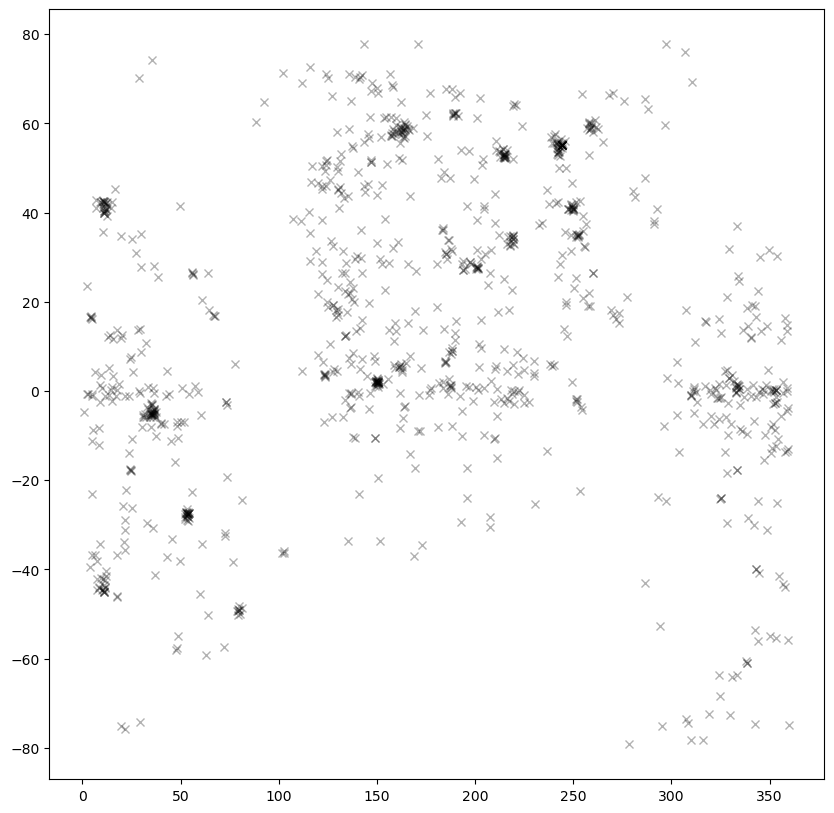

In [24]:
plt.figure(figsize=(10,10))
plt.plot(gfcat_unique_targets['ra'],gfcat_unique_targets['dec'],'kx',alpha=0.3)